# Training VGG-16 on Covid-16 x-ray chest images

This notebook contains the implementation of VGG-16 and its training on Covid-19 chest x-ray images. The dataset contains normal x-rays, covid x-rays and viral pneumonia x-rays.

The dataset is downloaded from Kaggle: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

In [2]:
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchinfo import summary

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
path_dataset = Path("data/covid-19-chest-x-ray/Covid19-dataset/")
class_to_idx = {"Normal": 0, "Covid": 1, "Viral Pneumonia": 2}

In [5]:
class Covid19Dataset(Dataset):
    def __init__(self, img_dir, transform=None) -> None:
        self.img_dir = img_dir
        self.transform = transform

        normal = list((img_dir/ "Normal").iterdir())
        covid = list((img_dir/ "Covid").iterdir())
        viral_pneumonia = list((img_dir/ "Viral Pneumonia").iterdir())

        self.files_path = normal + covid + viral_pneumonia

    def __len__(self):
        return len(self.files_path)
        

    def __getitem__(self, index):
        image_path = self.files_path[index]
        image = Image.open(image_path).convert('RGB')

        label = image_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
def get_loaders(path_dataset, batch_size: int, val_split: float = 0.1, random_seed: int = 42, shuffle: bool = True):

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ])

    train_dataset = Covid19Dataset(path_dataset/ "train", transform=train_transform)
    val_dataset = Covid19Dataset(path_dataset/ "train", transform=test_transform)
    test_dataset = Covid19Dataset(path_dataset/ "test", transform=test_transform)
    
    len_train = int(np.floor(len(train_dataset) * (1 - val_split)))
    len_val = len(train_dataset) - len_train
    

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_split * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


Display images from the dataset

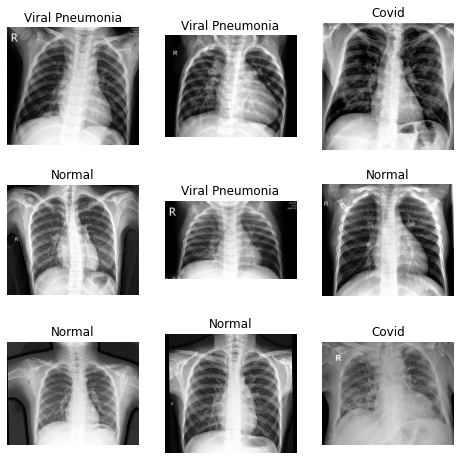

In [7]:
ds = Covid19Dataset(path_dataset/ "train")
labels_map = {
    0: "Normal",
    1: "Covid",
    2: "Viral Pneumonia"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [8]:
batch_size = 32

In [9]:
train_dataloader, val_dataloader, test_dataloader = get_loaders(path_dataset, batch_size, )

## Create VGG-16 model

In [10]:
class VGG16(nn.Module):

    def __init__(self, num_classes: int) -> None:
        super().__init__()

        self.features = nn.Sequential(
            # layer 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # layer 2
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # layer 4
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 5
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # layer 6
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 7
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # layer 8
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # layer 9
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 10
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # layer 11
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # layer 12
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            # fc1
            nn.Dropout(),
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(),
            # fc2
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            # fc3
            nn.Linear(4096, num_classes)
        )


    def forward(self, x: torch.tensor):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [11]:
num_classes = len(class_to_idx)

In [12]:
model = VGG16(num_classes)

In [13]:
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 3]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 112, 112]        256
│    └─ReLU: 2-10                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [1, 128, 112, 112]        147,

## Train model on Covid dataset

In [14]:
num_epochs = 40
learning_rate = 0.005
weight_decay_rate = 0.0005
# momentum = 0.9

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate ,momentum=0.9)

In [16]:
total_steps = len(train_dataloader)

In [17]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            correct += (preds == labels).sum()
            total += labels.size(0)

        acc = 100 * correct / total

    print(f"Validation accuracy: {acc:.2f}%")

Epoch [1/40], loss: 2.0707
Validation accuracy: 41.43%
Epoch [2/40], loss: 1.1735
Validation accuracy: 44.22%
Epoch [3/40], loss: 1.0620
Validation accuracy: 45.82%
Epoch [4/40], loss: 1.1451
Validation accuracy: 54.18%
Epoch [5/40], loss: 1.1313
Validation accuracy: 54.98%
Epoch [6/40], loss: 1.1114
Validation accuracy: 57.77%
Epoch [7/40], loss: 1.0529
Validation accuracy: 58.57%
Epoch [8/40], loss: 1.1062
Validation accuracy: 56.97%
Epoch [9/40], loss: 1.0867
Validation accuracy: 58.57%
Epoch [10/40], loss: 0.9531
Validation accuracy: 55.78%
Epoch [11/40], loss: 1.5033
Validation accuracy: 63.35%
Epoch [12/40], loss: 1.2531
Validation accuracy: 58.57%
Epoch [13/40], loss: 1.0264
Validation accuracy: 64.94%
Epoch [14/40], loss: 0.9451
Validation accuracy: 76.10%
Epoch [15/40], loss: 0.9324
Validation accuracy: 86.06%
Epoch [16/40], loss: 0.8265
Validation accuracy: 90.44%
Epoch [17/40], loss: 0.5215
Validation accuracy: 92.03%
Epoch [18/40], loss: 1.1513
Validation accuracy: 80.88%
E

In [19]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} % ')

Test accuracy: 83.33 % 
